In [1]:
import numpy as np
import torch
import gymnasium as gym
import random

from scripts.sac import *
from scripts.action_embedding_net import *
from scripts.save_everything import *
from scripts.load_everything import *
from scripts.generate_everything import *


# Make environment deterministic for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# different environments

In [ ]:
# Create the environment
env_name = "HalfCheetah-v4"
env = gym.make(env_name)
env.action_space.seed(42)
env.reset(seed=42)

state_dim = env.observation_space.shape[0]
is_discrete = isinstance(env.action_space, gym.spaces.Discrete)
if is_discrete:
    action_dim = env.action_space.n
else:
    action_dim = env.action_space.shape[0]

print(f"State dimension: {state_dim}, Action dimension: {action_dim}, Discrete: {is_discrete}")

In [5]:
env_name = "LunarLanderContinuous-v2"
env = gym.make(env_name)
env.action_space.seed(42)
env.reset(seed=42)
state_dim = env.observation_space.shape[0]
is_discrete = isinstance(env.action_space, gym.spaces.Discrete)
if is_discrete:
    action_dim = env.action_space.n
else:
    action_dim = env.action_space.shape[0]
print(f"State dimension: {state_dim}, Action dimension: {action_dim}, Discrete: {is_discrete}")

State dimension: 8, Action dimension: 2, Discrete: False


# record the training models

  0%|          | 0/100 [00:00<?, ?it/s]

Episode: 10, Avg. Reward: -228.92
Saved episode 10 model
Episode: 20, Avg. Reward: -180.79
Saved episode 20 model
Episode: 30, Avg. Reward: -70.61
Saved episode 30 model
Episode: 40, Avg. Reward: -57.20
Saved episode 40 model
Episode: 50, Avg. Reward: -107.98
Saved episode 50 model
Episode: 60, Avg. Reward: 54.35
Saved episode 60 model
Episode: 70, Avg. Reward: 56.87
Saved episode 70 model
Episode: 80, Avg. Reward: 67.32
Saved episode 80 model
Episode: 90, Avg. Reward: 28.21
Saved episode 90 model
Episode: 100, Avg. Reward: 99.10
Saved episode 100 model


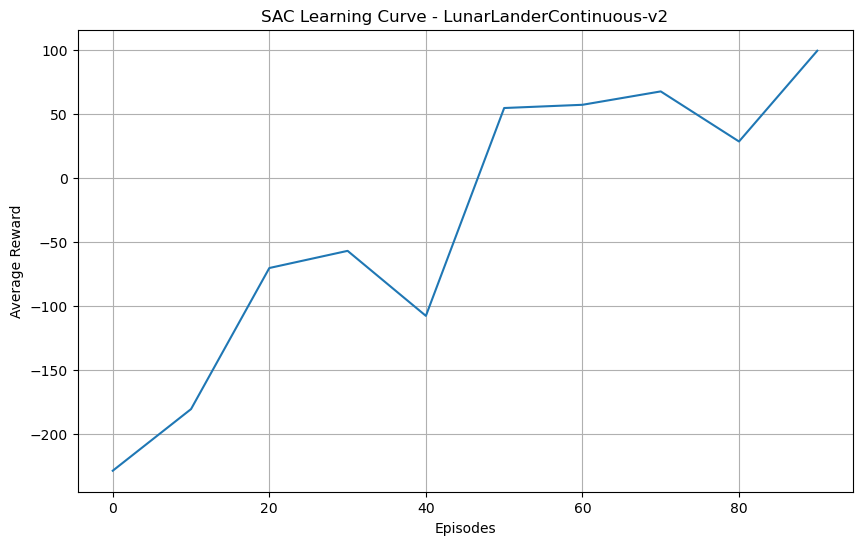

In [6]:

agent = SAC(
    state_dim=state_dim,
    action_dim=action_dim,
    action_space=env.action_space,
    lr=3e-4,
    hidden_dim=256,
    buffer_size=1000000,
    batch_size=256,
    tau=0.005,
    gamma=0.99,
    alpha=0.2,
    auto_entropy_tuning=True,
    is_discrete=is_discrete
    )
# save the initial model
agent.save('./tracking', f"episode_0.pth")

# Training parameters
num_episodes = 100
max_steps = 1000
eval_interval = 10
    
# Train the agent
episode_rewards, avg_rewards = train_record(env_name, agent, num_episodes, max_steps, eval_interval, record_interval=10)


Total reward: 261.84


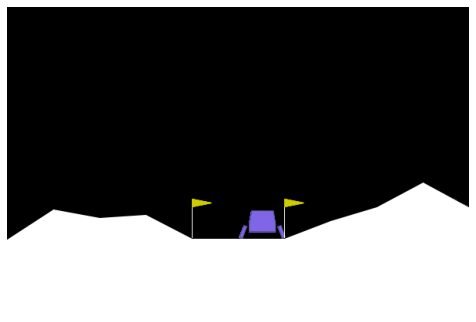

In [9]:
# render policy
frame = render_policy(env_name, agent, max_steps=max_steps)

# load the embedding model

In [ ]:
state_action_model, action_model = load_embedding_models(state_dim, action_dim)

# generate dataset for all inter-models

In [ ]:
# load every model in dir tracking and for each model generate 10 trajectories
for filename in os.listdir("tracking"):
    if filename.endswith('.pth'):
        agent = SAC(
            state_dim=state_dim,
            action_dim=action_dim,
            action_space=env.action_space,
            lr=3e-4,
            hidden_dim=256,
            buffer_size=1000000,
            batch_size=256,
            tau=0.005,
            gamma=0.99,
            alpha=0.2,
            auto_entropy_tuning=True
        )
        agent = load_agent(env, os.path.join("tracking", filename))
        print(f"Loaded model: {filename}")
        
        # Generate trajectories
        trajectories, offline_dataset = generate_expert_trajectories(env, agent, num_trajectories=10, max_steps=1000)
        print(f"Generated trajectories for model: {filename}")
        sa_embeddings, a_embeddings = generate_all_embeddings(offline_dataset, state_action_model, action_model)
        print(f"Generated embeddings for model: {filename}")
        # Save the embeddings
        save_embeddings(sa_embeddings, a_embeddings, directory="tracking_embeddings", prefix=filename[:-4])
        print(f"Saved embeddings for model: {filename}")


# evolution of the embedding

In [ ]:
sa_list, a_list = {}, {}

# make the embedding evolution plot
for filename in os.listdir("tracking"):
    if filename.endswith('.pth'):
        sa_embeddings = np.load(os.path.join("tracking_embeddings", filename.replace('.pth', 'state_action_embeddings.npy')))
        a_embeddings = np.load(os.path.join("tracking_embeddings", filename.replace('.pth', 'action_embeddings.npy')))
        sa_list[int(filename[8:-4])//10] = sa_embeddings
        a_list[int(filename[8:-4])//10] = a_embeddings
        print(f"Loaded embeddings for model: {filename}")

In [ ]:
sa_evolution, a_evolution = [], []
for i in range(len(sa_list)):
    sa_evolution.append(sa_list[i])
    a_evolution.append(a_list[i])

In [ ]:
visualize_embeddings_evolution(sa_evolution[:5], "State-Action Embeddings Evolution", "State-Action Embeddings Evolution.png")

In [ ]:
visualize_embeddings_evolution(a_evolution[1:5], "Action Embeddings Evolution", "Action Embeddings Evolution.png")

In [ ]:
visualize_embeddings_evolution(sa_evolution[1:], 'sa', 'sa_revolution.png', n_samples=1e5)

In [ ]:
visualize_embeddings_evolution(a_evolution[1:], 'sa', 'sa_revolution.png', n_samples=1e5)